In [14]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from PIL import Image
import matplotlib.pyplot as plt
import os, sys

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

N_COMPONENTS=30

#fold = int(os.environ['SLURM_ARRAY_TASK_ID'])
fold = 1
flx_data_path = "/work/mk423/Anxiety/flx_kf_dict_fold_{}.pkl".format(fold)
epm_data_path = "/work/mk423/Anxiety/epm_kf_dict_fold_{}.pkl".format(fold)
oft_data_path = "/work/mk423/Anxiety/oft_kf_dict_fold_{}.pkl".format(fold)
anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/work/mk423/Anxiety/kfold_models/"
saved_model_name = "try_3_kf_fold_{}_model.pt".format(fold)

results_path = "/hpc/home/mk423/Anxiety/FullDataWork/Validations/"
results_file = results_path + "try_3_fold_{}_results.pkl".format(fold)

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
    X_3d = np.zeros((n_rois,n_rois,n_freqs))
    
    for i in range(n_rois):
        X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]
        
    
    split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
    #print(split_coh_features)
    unique_coh_features = np.unique(split_coh_features)
    for i in range(n_rois):
        for j in range(n_rois):
            if i != j:
                area_1 = areas[i]
                area_2 = areas[j]
                temp_feature = area_1 + "-" + area_2
                temp_feature_2 = area_2 + "-" + area_1
                if temp_feature in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature,True,False)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                elif temp_feature_2 in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                else:
                    print("temp_feature: {} not found".format(temp_feature))

    return X_3d

with open(flx_data_path,"rb") as f:
    flx_dict = pickle.load(f)
    
with open(epm_data_path,"rb") as f:
    epm_dict = pickle.load(f)
    
with open(oft_data_path,"rb") as f:
    oft_dict = pickle.load(f)
    
with open(anx_info_dict,"rb") as f:
    info_dict = pickle.load(f)
    
feature_groups = [(0,len(info_dict["powerFeatures"])),
                   (len(info_dict["powerFeatures"]),len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"])),
                   (len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"]),
                    len(info_dict["powerFeatures"])+len(info_dict["cohFeatures"])+len(info_dict["gcFeatures"]))]
                   
mt_X_train = np.vstack([flx_dict["X_train"],epm_dict["X_train"],oft_dict["X_train"]])
mt_y_train = np.hstack([flx_dict["y_train"],epm_dict["y_train"],oft_dict["y_train"]]).reshape(-1,1)
mt_y_mouse_train = np.hstack([flx_dict["y_mouse_train"],epm_dict["y_mouse_train"],oft_dict["y_mouse_train"]])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))

mt_X_val = np.vstack([flx_dict["X_val"],epm_dict["X_val"],oft_dict["X_val"]])
mt_y_val = np.hstack([flx_dict["y_val"],epm_dict["y_val"],oft_dict["y_val"]]).reshape(-1,1)
mt_y_mouse_val = np.hstack([flx_dict["y_mouse_val"],epm_dict["y_mouse_val"],oft_dict["y_mouse_val"]])

TRAIN = False
if TRAIN:
    model = DcsfaNmf(
        n_components=N_COMPONENTS,
        n_intercepts=intercept_mask.shape[1],
        optim_name="SGD",
        recon_loss="MSE",
        feature_groups=feature_groups,
        fixed_corr=["positive"],
        save_folder=saved_model_path,
    )

    model.fit(mt_X_train,
              mt_y_train,
              intercept_mask=intercept_mask,
              y_sample_groups=sample_groups,
              batch_size=128,
              lr=1e-3,
              n_pre_epochs=1000,
              n_epochs=3000,
              nmf_max_iter=3000,
              pretrain=True,
              verbose=True,
              best_model_name=saved_model_name)

    torch.save(model,saved_model_path + saved_model_name)
else:
    model = torch.load(saved_model_path + saved_model_name)


In [15]:
#Multitask Performance
mt_train_auc = model.score(mt_X_train,mt_y_train)
mt_val_auc = model.score(mt_X_val,mt_y_val)

#FLX Performance
flx_train_auc = model.score(flx_dict["X_train"],flx_dict["y_train"].reshape(-1,1),
                           flx_dict['y_mouse_train'],return_dict=True)
flx_val_auc = model.score(flx_dict["X_val"],flx_dict["y_val"].reshape(-1,1),
                          flx_dict["y_mouse_val"],return_dict=True)

#EPM Performance
epm_train_auc = model.score(epm_dict["X_train"],epm_dict["y_train"].reshape(-1,1),
                           epm_dict["y_mouse_train"],return_dict=True)
epm_val_auc = model.score(epm_dict["X_val"],epm_dict["y_val"].reshape(-1,1),
                          epm_dict["y_mouse_val"],return_dict=True)

#OFT Performance
oft_train_auc = model.score(oft_dict["X_train"],oft_dict["y_train"].reshape(-1,1),oft_dict['y_mouse_train'],return_dict=True)
oft_val_auc = model.score(oft_dict["X_val"],oft_dict["y_val"].reshape(-1,1),oft_dict['y_mouse_val'],return_dict=True)

s = model.project(mt_X_val)
X_sup_recon = model.get_comp_recon(torch.Tensor(s).to("cuda"),0)
X_recon = model.reconstruct(mt_X_val)

recon_contribution = np.mean(X_sup_recon/X_recon,axis=0)
rec_psd = recon_contribution[:len(info_dict["powerFeatures"])]
rec_coh = recon_contribution[len(info_dict["powerFeatures"]):(len(info_dict["powerFeatures"]) + len(info_dict["cohFeatures"]))]
rec_3d = reshapeData(rec_psd,rec_coh,8,56,info_dict["powerFeatures"],info_dict["cohFeatures"],info_dict["area"])

#circle_plot(rec_3d,info_dict["area"],freqs=np.arange(56),freq_ticks=np.arange(0,56,5),
#            min_max_quantiles=(0.85,0.9999),fn=plots_path + "fold_{}_electome.png".format(fold))

#umc_dt.makeUpperTriangularPlot_pow_coh_gc(recon_contribution.reshape(1,-1),info_dict["area"],info_dict["powerFeatures"],
#                                          info_dict["cohFeatures"],info_dict["gcFeatures"],
#                                          saveFile=plots_path + "fold_{}_uptri.png".format(fold))

results_dict = {
    "flx_train_auc":flx_train_auc,
    "flx_val_auc":flx_val_auc,
    "epm_train_auc":epm_train_auc,
    "epm_val_auc":epm_val_auc,
    "oft_train_auc":oft_train_auc,
    "oft_val_auc":oft_val_auc,
    "recon_cont":recon_contribution,
}

#with open(results_file,"wb") as f:
#    pickle.dump(results_dict,f)

In [25]:
oft_val_auc

{'Mouse04191': [0.5343522945450438],
 'Mouse04193': [0.728167058965538],
 'Mouse04201': [0.8114579239880986],
 'Mouse04202': [0.6981465674917693]}

In [9]:
model.score(flx_dict["X_val"],flx_dict["y_val"].reshape(-1,1),
                          flx_dict["y_mouse_val"],return_dict=False)

ValueError: need at least one array to concatenate

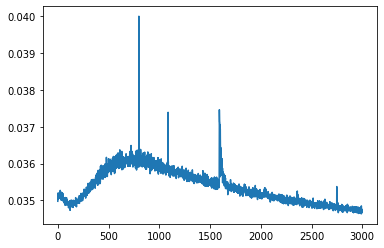

In [37]:
import matplotlib.pyplot as plt
plt.plot(model.recon_hist)
plt.show()

In [10]:
flx_dict["X_val"].shape

(0, 5152)